In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
import keras
from keras_tuner import HyperModel, GridSearch
from utils import clf_report_to_df, plot_confusion_matrix

In [2]:
RANDOM_SEED=42
RESULTS_DIR="./results"
MODEL_NAME="CNN"
np.random.seed(RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)

In [3]:
data = np.load('./dataset/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_dev = data['X_dev']
y_dev = data['y_dev']
X_test = data['X_test']
y_test = data['y_test']
y_mapping = data['y_mapping']

In [4]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self, hp):
        input_layer = keras.layers.Input(shape=self.input_shape)

        filters = hp.Choice('filters', values=[32])#, 16, 32
        num_conv_layers = hp.Choice('num_conv_layers', values=[2])#, 3]) # TODO: 3,4?
        dropout_rate = hp.Choice('dropout_rate', values=[0.3])#, 0.0])
        lr = hp.Choice('learning_rate', values=[1e-3])#, 1e-4, 1e-3, 1e-2])

        x = input_layer
        for _ in range(num_conv_layers):
            x = keras.layers.Conv1D(filters=filters, kernel_size=3, padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            x = keras.layers.Dropout(rate=dropout_rate)(x)

        x = keras.layers.GlobalAveragePooling1D()(x)
        output_layer = keras.layers.Dense(self.num_classes, activation='softmax')(x)

        model = keras.models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss='sparse_categorical_crossentropy', # labels are integers, not one-hot encoded
            metrics=['sparse_categorical_accuracy']
        )
        return model

tuner = GridSearch(
    CNNHyperModel(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_train))),
    objective='val_sparse_categorical_accuracy',
    seed=RANDOM_SEED,
    overwrite=True,
    directory=RESULTS_DIR,
    project_name='CNN_tuning'
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32], 'ordered': True}
num_conv_layers (Choice)
{'default': 2, 'conditions': [], 'values': [2], 'ordered': True}
dropout_rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001], 'ordered': True}


In [5]:
num_epochs = 500
batch_size = 16
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)
tuner.search(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        early_stopping,
        lr_scheduler
    ],
    verbose=1
)

Trial 1 Complete [00h 00m 24s]
val_sparse_categorical_accuracy: 0.6883116960525513

Best val_sparse_categorical_accuracy So Far: 0.6883116960525513
Total elapsed time: 00h 00m 24s


In [6]:
def get_trials_df(tuner):
    trials = tuner.oracle.trials.values()
    hps = []
    for trial in trials:
        hp_values = trial.hyperparameters.get_config()["values"]
        hp_values["val_loss"] = trial.score
        hps.append(hp_values)
    hp_df = pd.DataFrame(hps)
    hp_df = hp_df.sort_values(by="val_loss")
    return hp_df.style.background_gradient(cmap="Blues", subset=["val_loss"])

In [7]:
get_trials_df(tuner)

,filters,num_conv_layers,dropout_rate,learning_rate,val_loss
0,32,2,0.300000,0.001000,0.688312


In [8]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model._name = MODEL_NAME
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 150, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 150, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 150, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 150, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,304 (16.81 KB)

 Trainable params: 4,176 (16.31 KB)

 Non-trainable params: 128 (512.00 B)

In [9]:
history = best_model.fit(
    X_dev, y_dev,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[
        early_stopping,
        lr_scheduler
    ],
    verbose=1
)
best_model.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}.keras"))

Epoch 1/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7415 - sparse_categorical_accuracy: 0.0792 - val_loss: 2.7340 - val_sparse_categorical_accuracy: 0.0857 - learning_rate: 0.0010
Epoch 2/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4508 - sparse_categorical_accuracy: 0.1812 - val_loss: 2.7103 - val_sparse_categorical_accuracy: 0.1143 - learning_rate: 0.0010
Epoch 3/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3250 - sparse_categorical_accuracy: 0.3169 - val_loss: 2.6697 - val_sparse_categorical_accuracy: 0.1571 - learning_rate: 0.0010
Epoch 4/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2294 - sparse_categorical_accuracy: 0.3526 - val_loss: 2.6114 - val_sparse_categorical_accuracy: 0.1857 - learning_rate: 0.0010
Epoch 5/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1635 - sparse_categorical_accuracy: 0.3656 - val_loss: 2.5343 - val_sparse_categorical_accuracy: 0.1571 - learning_rate: 0.0010
Epoch 6/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

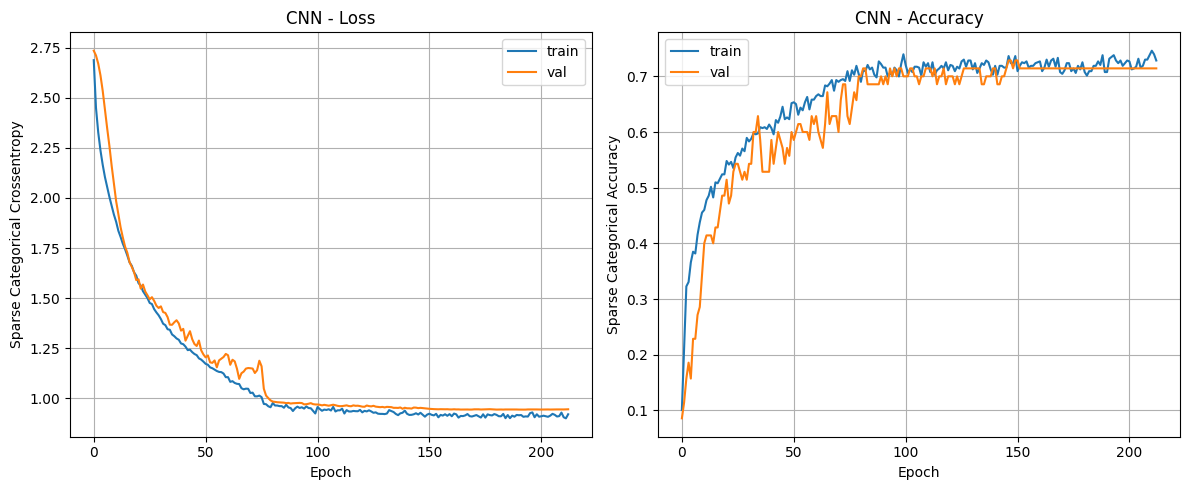

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history["loss"], label="train")
ax1.plot(history.history["val_loss"], label="val")
ax1.set_title(f"{MODEL_NAME} - Loss")
ax1.set_ylabel("Sparse Categorical Crossentropy")
ax1.set_xlabel("Epoch")
ax1.grid()
ax1.legend()

ax2.plot(history.history["sparse_categorical_accuracy"], label="train")
ax2.plot(history.history["val_sparse_categorical_accuracy"], label="val")
ax2.set_title(f"{MODEL_NAME} - Accuracy")
ax2.set_ylabel("Sparse Categorical Accuracy")
ax2.set_xlabel("Epoch")
ax2.grid()
ax2.legend()

fig.tight_layout()

In [11]:
train_loss, train_accuracy = best_model.evaluate(X_train, y_train)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Loss": [train_loss, test_loss],
    "Accuracy": [train_accuracy, test_accuracy]
}).set_index("Dataset")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8495 - sparse_categorical_accuracy: 0.7940 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1364 - sparse_categorical_accuracy: 0.6860


,Loss,Accuracy
Dataset,,
Train,0.840352,0.772213
Test,1.133709,0.692308


In [12]:
y_pred_proba = best_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_report = classification_report(y_test_str, y_pred_str, output_dict=True)
clf_scores_df, per_class_clf_scores_df = clf_report_to_df(
    clf_report,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_per_class_clf_scores.csv")
)

clf_scores_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.692308,0.692235,0.681281,0.7,0.697009,0.711458,0.692308


In [13]:
per_class_clf_scores_df.style.background_gradient(cmap="Blues")

,precision,recall,f1-score,support
ball,0.750000,0.750000,0.750000,4.000000
bigball,0.500000,0.600000,0.545455,5.000000
box,0.833333,1.000000,0.909091,5.000000
button,0.750000,0.500000,0.600000,6.000000
case,0.800000,0.800000,0.800000,5.000000
cube,0.666667,0.800000,0.727273,5.000000
cylinder,0.600000,0.600000,0.600000,5.000000
jenga,0.666667,0.800000,0.727273,5.000000
labello,0.750000,0.600000,0.666667,5.000000
lemon,0.750000,0.600000,0.666667,5.000000


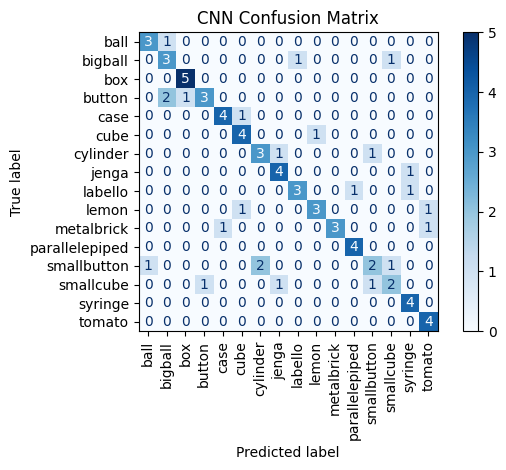

In [14]:
plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_confusion_matrix.png")
)